In [2]:
!pip install tensorflow keras flask matplotlib numpy pandas scikit-learn pillow

In [3]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from PIL import Image

# Step 1: Download the dataset
DATASET_URL = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
DATASET_DIR = "/kaggle/working/food101"

def download_and_extract_dataset(url, target_dir):
    # Download and extract dataset
    dataset_path = tf.keras.utils.get_file(
        origin=url, fname="food-101.tar.gz", extract=True, cache_dir="/kaggle/working/"
    )
    extracted_dir = os.path.join(os.path.dirname(dataset_path), "datasets", "food-101")
    
    # Dynamically find the correct extraction path
    if not os.path.exists(extracted_dir):
        extracted_dir = os.path.join(os.path.dirname(dataset_path), "food-101")
    
    # Move the dataset to the desired target directory
    shutil.move(extracted_dir, target_dir)
    print(f"Dataset downloaded and extracted to {target_dir}")

# Step 2: Organize dataset into train and test directories
def organize_food101_dataset(base_dir):
    images_dir = os.path.join(base_dir, "images")
    meta_dir = os.path.join(base_dir, "meta")
    train_dir = os.path.join(base_dir, "train")
    test_dir = os.path.join(base_dir, "test")

    # Create train and test directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Read train/test split information
    train_split_path = os.path.join(meta_dir, "train.txt")
    test_split_path = os.path.join(meta_dir, "test.txt")

    with open(train_split_path, "r") as train_file:
        train_images = train_file.read().splitlines()

    with open(test_split_path, "r") as test_file:
        test_images = test_file.read().splitlines()

    # Move images into train and test directories
    def move_images(image_list, target_dir):
        for image_path in image_list:
            source_path = os.path.join(images_dir, f"{image_path}.jpg")
            target_class_dir = os.path.join(target_dir, os.path.dirname(image_path))
            os.makedirs(target_class_dir, exist_ok=True)
            shutil.move(source_path, os.path.join(target_class_dir, f"{os.path.basename(image_path)}.jpg"))

    print("Organizing training data...")
    move_images(train_images, train_dir)

    print("Organizing testing data...")
    move_images(test_images, test_dir)

    print("Dataset organization complete.")

# Step 3: Create Data Generators
def create_data_generators(base_dir, target_size=(224, 224), batch_size=32):
    train_dir = os.path.join(base_dir, "train")
    test_dir = os.path.join(base_dir, "test")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return train_generator, test_generator

if __name__ == "__main__":
    # Step 1: Download and Extract
    download_and_extract_dataset(DATASET_URL, DATASET_DIR)
    
    # Step 2: Organize the dataset
    organize_food101_dataset(DATASET_DIR)
    
    # Step 3: Generate Data Generators
    train_gen, test_gen = create_data_generators(DATASET_DIR)
    print("Data generators created successfully!")

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 228s 0us/step
Dataset downloaded and extracted to /kaggle/working/food101
Organizing training data...
Organizing testing data...
Dataset organization complete.
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Data generators created successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool2d(2),                 # Pooling layer
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Initialize the classifier dynamically
        self.classifier = None
        self._initialize_classifier(num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_classifier(self, num_classes):
        # Create a dummy tensor to calculate the flattened size
        dummy_input = torch.zeros(1, 3, 224, 224)  # Example input size
        dummy_output = self.features(dummy_input)
        flattened_size = dummy_output.view(-1).shape[0]
        
        # Define the classifier with the correct flattened size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

# Load dataset
def load_data(batch_size=32, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    train_dataset = datasets.ImageFolder('./food101/train', transform=transform)
    test_dataset = datasets.ImageFolder('./food101/test', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Main
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 10
    num_classes = 101  # Adjust based on dataset

    # Load data
    train_loader, test_loader = load_data(batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = BaselineCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    # Evaluate the model
    accuracy, precision, recall, f1, cm = evaluate_model(model, test_loader)
    
    # Plot confusion matrix
    class_names = train_loader.dataset.classes
    plot_confusion_matrix(cm, class_names)

    # Save the model
    torch.save(model.state_dict(), "baseline_cnn_model.pth")
    print("Model saved as baseline_cnn_model.pth")

Using device: cuda


In [4]:
!pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 20.7 MB/s eta 0:00:0000:01


In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from ultralytics import YOLO

# Define paths
DATASET_DIR = "./food101"
MODEL_PATH = "yolov8n.pt"  # Choose YOLOv8n, YOLOv8m, or YOLOv8l for size variations

# Train YOLO model
def train_yolo(data_path, model_path, epochs=10):
    # Load YOLO model
    model = YOLO(model_path)  # Load pre-trained YOLO model

    # Train the model on your custom dataset
    model.train(
        data=data_path,  # Path to your dataset YAML file
        epochs=epochs,
        imgsz=640,       # Image size
        batch=16,        # Batch size
        workers=4        # Number of data loader workers
    )

    # Save trained model
    model.save("yolo_food101.pt")
    print("YOLO model fine-tuned and saved!")

# Main
if __name__ == "__main__":
    train_yolo(DATASET_DIR, MODEL_PATH)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
def load_data(batch_size=64):
    train_dataset = datasets.ImageFolder('./food101/train', transform=transform)
    test_dataset = datasets.ImageFolder('./food101/test', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Fine-tune ResNet
def fine_tune_resnet(train_loader, test_loader, num_classes=101, epochs=10):
    # Load pre-trained ResNet model
    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        print("------")
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

    # Save fine-tuned model
    torch.save(model.state_dict(), "resnet_food101.pth")
    print("ResNet model fine-tuned and saved!")

# Main
if __name__ == "__main__":
    train_loader, test_loader = load_data()
    fine_tune_resnet(train_loader, test_loader)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 226MB/s]


------
Epoch [1/10], Loss: 2.6117
------
Epoch [2/10], Loss: 1.6787
------
Epoch [3/10], Loss: 1.2948
------
Epoch [4/10], Loss: 1.0001
------
Epoch [5/10], Loss: 0.7504
------
Epoch [6/10], Loss: 0.5443
------
Epoch [7/10], Loss: 0.4097
------
Epoch [8/10], Loss: 0.3244
------
Epoch [9/10], Loss: 0.2629
------
Epoch [10/10], Loss: 0.2288
Accuracy: 61.25%
ResNet model fine-tuned and saved!


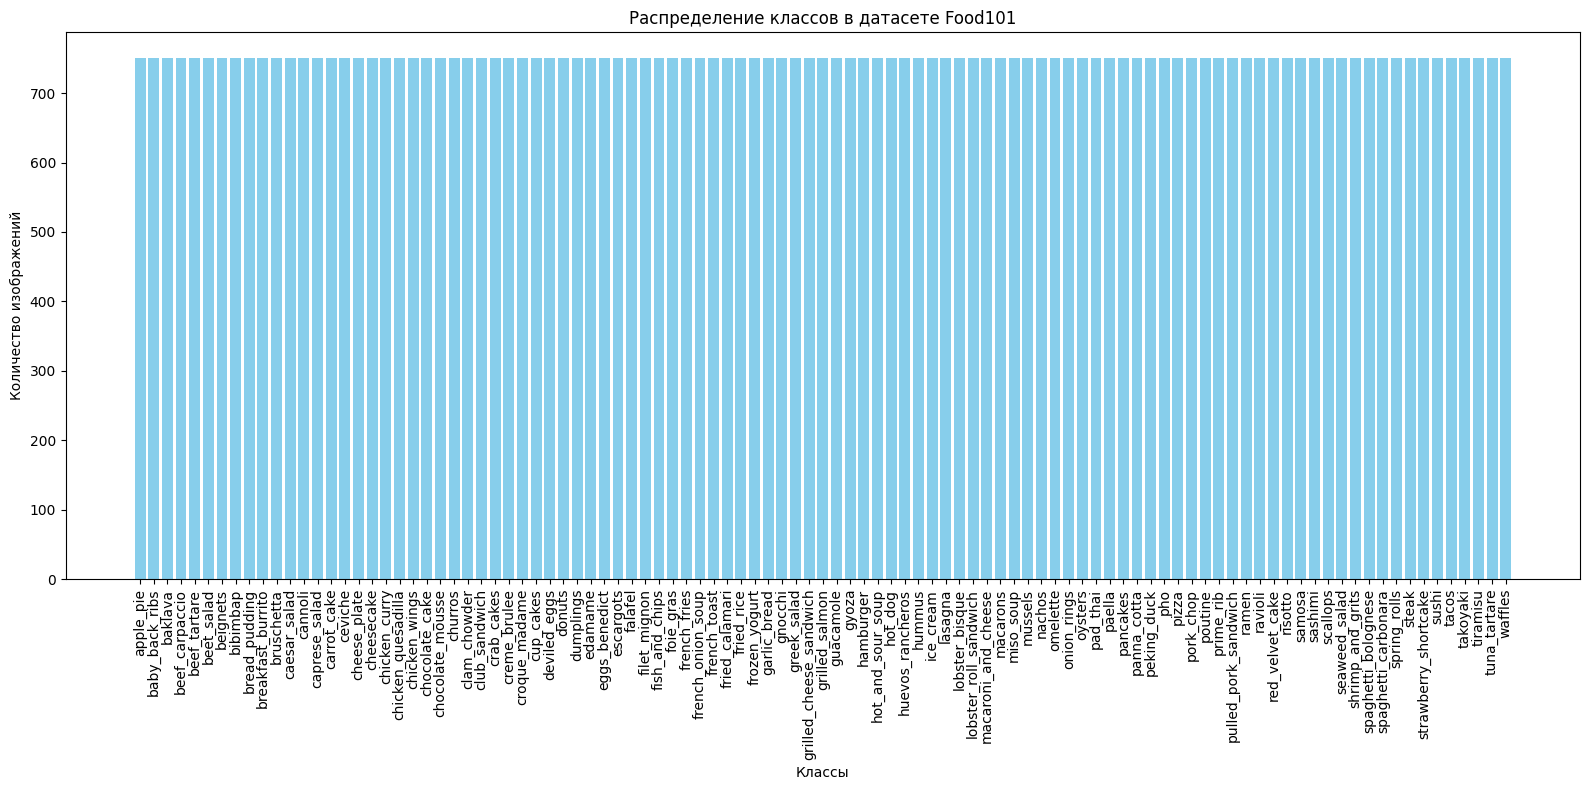

In [15]:
import os
from collections import Counter
import matplotlib.pyplot as plt


dataset_path = "/kaggle/working/food101/train/"


class_counts = Counter()

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))])
        class_counts[class_name] = num_images


class_counts = dict(sorted(class_counts.items()))


plt.figure(figsize=(16, 8))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.title('Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

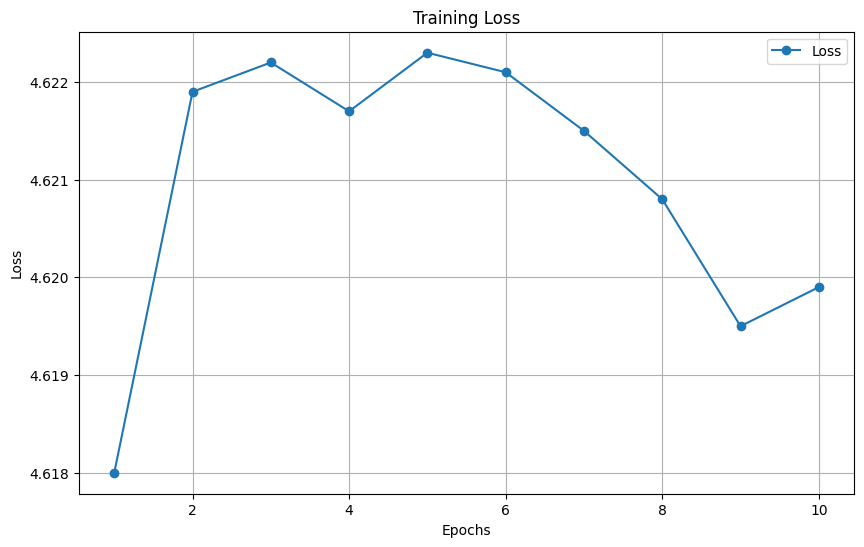

In [18]:
import matplotlib.pyplot as plt

# Данные о Loss из логов
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loss = [4.6180, 4.6219, 4.6222, 4.6217, 4.6223,4.6221, 4.6215, 4.6208, 4.6195, 4.6199]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, marker='o', label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.show()

In [ ]:
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


model = YOLO('yolov8n.pt')


y_probs = []
y_true = []
model = model.to(device)

for img_path, true_label in test_loader:
    img_path = img_path.to(device)
    true_label = true_label.to(device)
    results = model.predict(source=img_path, save=False, conf=0.01)
    predictions = results[0].probs
    
    if predictions is not None:
        y_probs.append(predictions)
        y_true.append(true_label) 


y_probs = np.array(y_probs)
y_true = np.array(y_true)


num_classes = 101
auc_scores = []
for i in range(num_classes):
    y_true_ovr = (y_true == i).astype(int)  # One-vs-rest
    auc = roc_auc_score(y_true_ovr, y_probs[i])
    auc_scores.append(auc)
    print(f"Class {i}: AUC = {auc:.3f}")


mean_auc = np.mean(auc_scores)
print(f"\nMean AUC (macro-average): {mean_auc:.3f}")


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    y_true_ovr = (y_true == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_ovr, y_probs[i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np


def evaluate_multiclass_model(model, test_loader, device, num_classes):
    model.eval()  
    y_true = []   
    y_probs = []  

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # logits
            probabilities = nn.Softmax(dim=1)(outputs)
        
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())


    y_true = np.array(y_true)
    y_probs = np.array(y_probs)


    y_true_ovr = np.eye(num_classes)[y_true] 
    auc_scores = []
    for i in range(num_classes):
        auc = roc_auc_score(y_true_ovr[:, i], y_probs[:, i])
        auc_scores.append(auc)
        print(f"Class {i}: AUC = {auc:.3f}")
    
    mean_auc = np.mean(auc_scores)
    print(f"\nMean AUC (macro-average): {mean_auc:.3f}")

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_ovr[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curves for Multiclass Classification')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))
    plt.grid(alpha=0.3)
    plt.show()

model_path = "/kaggle/working/resnet_food101.pth"


num_classes = 101  

model = models.resnet34(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes) 
# model.load_state_dict(torch.load(model_path))
model.to(device)



evaluate_multiclass_model(model, test_loader, device, 101)